In [1]:
from SpecReduction import SpecFunctions as sf
import numpy as np
import pandas as pd
import scipy
import scipy.optimize as opt
from scipy.optimize import curve_fit
import specreduce
from specreduce import WavelengthCalibration1D as wav_cal
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from aquarel import load_theme
from astropy import units as u
from skimage.transform import rotate

In [2]:
theme = load_theme('arctic_dark')
theme.apply()

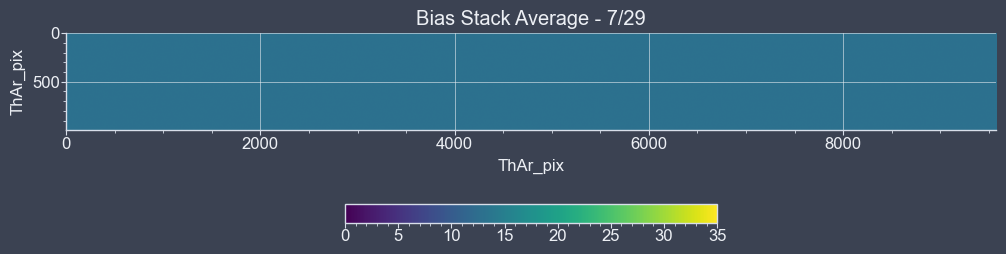

In [3]:
#median of bias frames stack (7/29) - from scratch
bias_path_729 = f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_'
bias_shape_729 = fits.open(f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_0067.FIT')[0].data.shape
bias_avg_729 = sf.median_img(100, bias_path_729, bias_shape_729[0], bias_shape_729[1])

plt.figure(figsize = (12,12))
plt.imshow(bias_avg_729)
plt.title('Bias Stack Average - 7/29')
plt.xlabel('ThAr_pix')
plt.ylabel('ThAr_pix')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

bias_729_hdu = fits.PrimaryHDU(bias_avg_729)
bias_729_hdu.writeto('FITS_shortcut/bias_729.fits', overwrite = True)

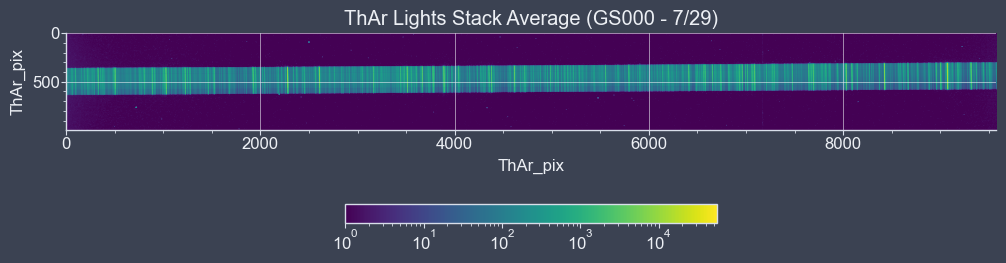

In [5]:
#median of ThAr lights stack (7/29) - from scratch
ThAr_lights_path_729 = f'Lab Day 20250729/ThAr_2s_lights/2025-07-29-2227_6-CapObj_'
ThAr_lights_shape_729 = fits.open(f'Lab Day 20250729/ThAr_2s_lights/2025-07-29-2227_6-CapObj_0010.FIT')[0].data.shape
ThAr_lights_avg_729 = sf.median_img(100, ThAr_lights_path_729, ThAr_lights_shape_729[0], ThAr_lights_shape_729[1])

ThAr_lights_avg_729 = ThAr_lights_avg_729 - bias_avg_729

plt.figure(figsize = (12,12))
plt.imshow(ThAr_lights_avg_729, norm = 'log')
plt.title('ThAr Lights Stack Average (GS000 - 7/29)')
plt.xlabel('ThAr_pix')
plt.ylabel('ThAr_pix')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

ThAr_lights_729_hdu = fits.PrimaryHDU(ThAr_lights_avg_729)
ThAr_lights_729_hdu.writeto('FITS_shortcut/ThAr729_lights.fits', overwrite = True)

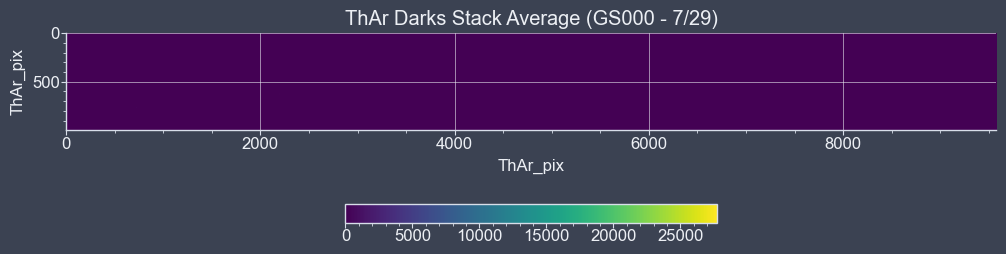

In [6]:
#median of ThAr darks stack (7/29) - from scratch
ThAr_darks_path_729 = f'Lab Day 20250729/ThAr_2s_darks/2025-07-29-2233_2-CapObj_'
ThAr_darks_shape_729 = fits.open(f'Lab Day 20250729/ThAr_2s_darks/2025-07-29-2233_2-CapObj_0028.FIT')[0].data.shape
ThAr_darks_avg_729 = sf.median_img(100, ThAr_darks_path_729, ThAr_darks_shape_729[0], ThAr_darks_shape_729[1])

ThAr_darks_avg_729 = ThAr_darks_avg_729 - bias_avg_729

plt.figure(figsize = (12,12))
plt.imshow(ThAr_darks_avg_729)
plt.title('ThAr Darks Stack Average (GS000 - 7/29)')
plt.xlabel('ThAr_pix')
plt.ylabel('ThAr_pix')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

ThAr_darks_729_hdu = fits.PrimaryHDU(ThAr_darks_avg_729)
ThAr_darks_729_hdu.writeto('FITS_shortcut/ThAr729_darks.fits', overwrite = True)

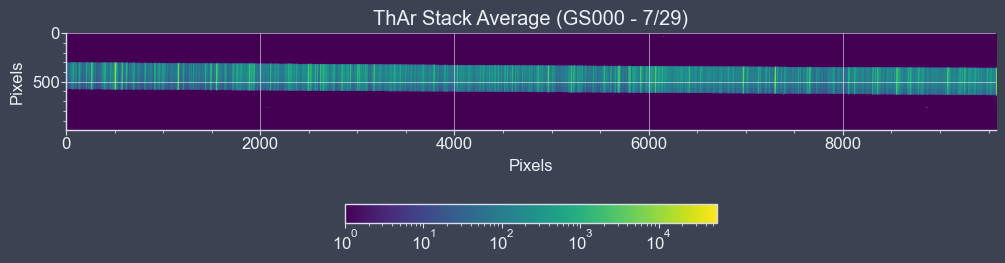

In [7]:
#subtraction - from scratch
ThAr_subtracted_729 = ThAr_lights_avg_729 - ThAr_darks_avg_729
ThAr_flipped_729 = np.fliplr(ThAr_subtracted_729)

plt.figure(figsize = (12,12))
plt.imshow(ThAr_flipped_729, norm = 'log')
plt.title('ThAr Stack Average (GS000 - 7/29)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08, norm = 'log')
plt.show()

ThAr_flipped_729_hdu = fits.PrimaryHDU(ThAr_flipped_729)
ThAr_flipped_729_hdu.writeto('FITS_shortcut/ThAr729_flipped.fits', overwrite = True)

(1.0, 509, 0.9607953817094216, 7294)
0.3799959137743957


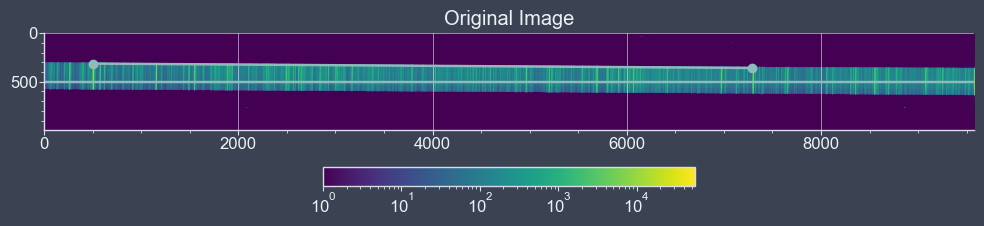

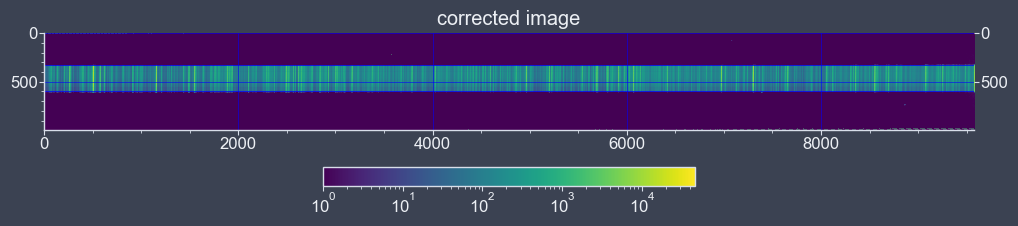

In [8]:
ThAr_flipped_729 = fits.open('FITS_shortcut/ThAr729_flipped.fits')[0].data
ThAr_flipped_729 = ThAr_flipped_729.byteswap().newbyteorder()
ThAr_corrected_729 = sf.straight_spec(ThAr_flipped_729)

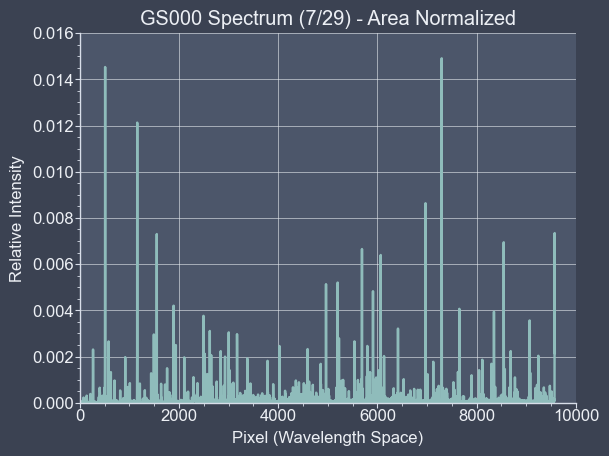

In [9]:
ThAr_spec_729 = sf.make1D(ThAr_corrected_729)
plt.plot(ThAr_spec_729)
plt.title('GS000 Spectrum (7/29) - Area Normalized')
plt.ylabel('Relative Intensity') #percentage of total intensity in each peak
plt.xlabel('Pixel (Wavelength Space)')
plt.xlim(0,10000)
plt.ylim(0, .016)
plt.show()

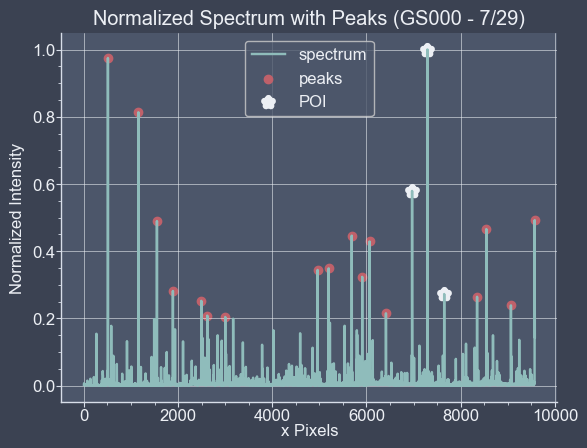

In [10]:
ThAr_spec_norm_729 = sf.make1D(ThAr_corrected_729, False)
ThAr_729_peak_locs, ThAr_729_peak_vals, ThAr_729_fw, ThAr_729_fwhm = sf.find_peaks(ThAr_spec_norm_729, 0.2)
plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS000 - 7/29)')
plt.plot(ThAr_spec_norm_729, label = 'spectrum')
plt.scatter(ThAr_729_peak_locs, ThAr_729_peak_vals, color = '#bf616a', label = 'peaks')

#finding triplet
for peak in range(len(ThAr_729_peak_locs)):
    if ThAr_729_peak_vals[peak] == 1:
        main_index = peak
        break
        
poi_loc = np.array([ThAr_729_peak_locs[main_index - 1], ThAr_729_peak_locs[main_index], ThAr_729_peak_locs[main_index + 1]])        
poi_i = np.array([ThAr_729_peak_vals[main_index - 1], ThAr_729_peak_vals[main_index], ThAr_729_peak_vals[main_index + 1]])

plt.scatter(poi_loc, poi_i, label = 'POI', color = '#eceff4', marker = '*', lw = 5)

plt.ylabel('Normalized Intensity')
plt.xlabel('x Pixels', va='center')
plt.legend()
plt.show()

In [11]:
UNe_peaks = pd.read_excel('quick_neon_lines.xlsx')

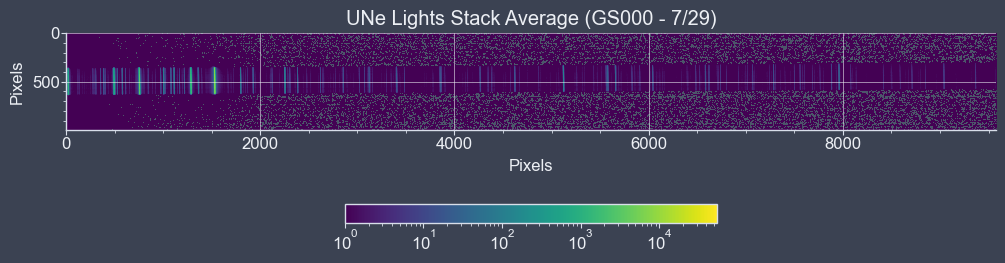

In [12]:
bias_avg_729 = fits.open('FITS_shortcut/bias_729.fits')[0].data
bias_avg_729 = bias_avg_729.byteswap().newbyteorder()
#median of UNe lights stack (7/29)
UNe_lights_path_729 = f'Lab Day 20250729/UNe_unsaturated_lights/2025-07-29-2126_9-CapObj_'
UNe_lights_shape_729 = fits.open(f'Lab Day 20250729/UNe_unsaturated_lights/2025-07-29-2126_9-CapObj_0072.FIT')[0].data.shape
UNe_lights_avg_729 = sf.median_img(100, UNe_lights_path_729, UNe_lights_shape_729[0], UNe_lights_shape_729[1])

UNe_lights_avg_729 = UNe_lights_avg_729 - bias_avg_729

plt.figure(figsize = (12,12))
plt.imshow(UNe_lights_avg_729, norm = 'log')
plt.title('UNe Lights Stack Average (GS000 - 7/29)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

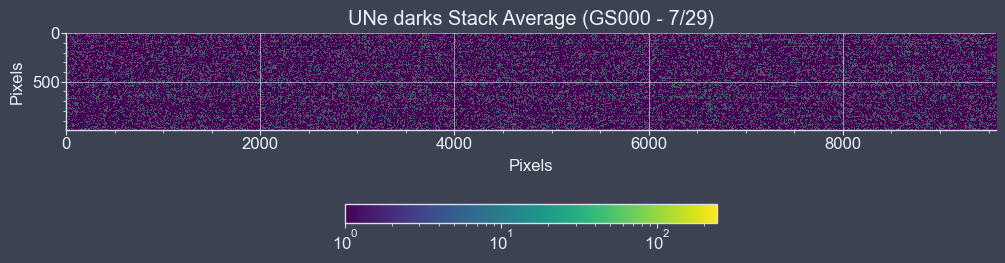

In [14]:
#median of UNe darks stack (7/29)
UNe_darks_path_729 = f'Lab Day 20250729/UNe_unsaturated_darks/2025-07-29-2129_8-CapObj_'
UNe_darks_shape_729 = fits.open(f'Lab Day 20250729/UNe_unsaturated_darks/2025-07-29-2129_8-CapObj_0091.FIT')[0].data.shape
UNe_darks_avg_729 = sf.median_img(100, UNe_darks_path_729, UNe_darks_shape_729[0], UNe_darks_shape_729[1])

UNe_darks_avg_729 = UNe_darks_avg_729 - bias_avg_729

plt.figure(figsize = (12,12))
plt.imshow(UNe_darks_avg_729, norm = 'log')
plt.title('UNe darks Stack Average (GS000 - 7/29)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

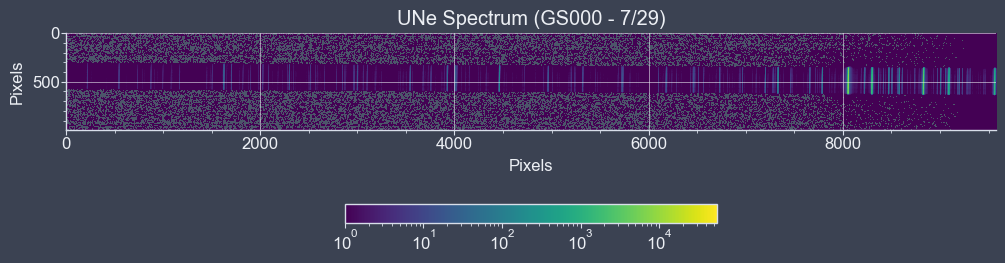

In [15]:
UNe_subtracted_729 = UNe_lights_avg_729 - UNe_darks_avg_729
UNe_flipped_729 = np.fliplr(UNe_subtracted_729)

plt.figure(figsize = (12,12))
plt.imshow(UNe_flipped_729, norm = 'log')
plt.title('UNe Spectrum (GS000 - 7/29)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

UNe_729_flipped_hdu = fits.PrimaryHDU(UNe_flipped_729)
UNe_729_flipped_hdu.writeto('FITS_shortcut/UNe_729_flipped.fits', overwrite = True)

(1.0, 8045, 0.3656301987042324, 8819)
-0.07402551373776525


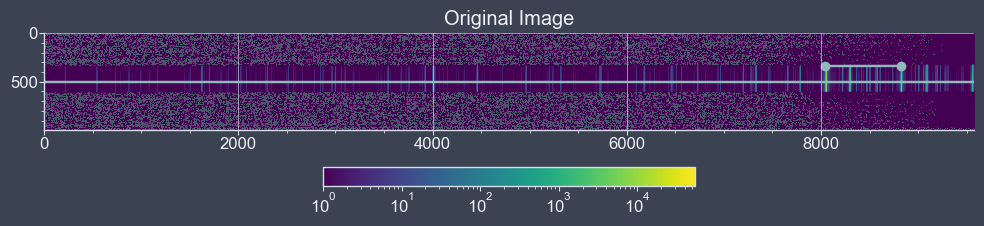

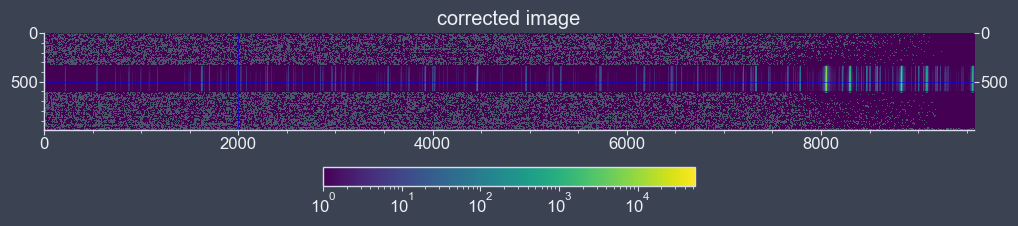

In [16]:
UNe_flipped_729 = fits.open('FITS_shortcut/UNe_729_flipped.fits')[0].data.byteswap().newbyteorder()

UNe_corrected_729 = rotate(UNe_flipped_729, 0.4)
UNe_corrected_729 = sf.straight_spec(UNe_corrected_729)

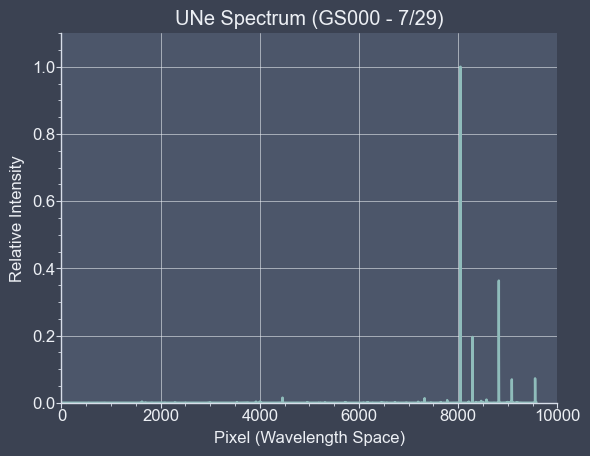

In [17]:
UNe_spec_729 = sf.make1D(UNe_corrected_729, False)

plt.plot(UNe_spec_729)
plt.title('UNe Spectrum (GS000 - 7/29)')
plt.ylabel('Relative Intensity') #percentage of total intensity in each peak
plt.xlabel('Pixel (Wavelength Space)')
plt.xlim(0,10000)
plt.ylim(0, 1.1)
plt.show()

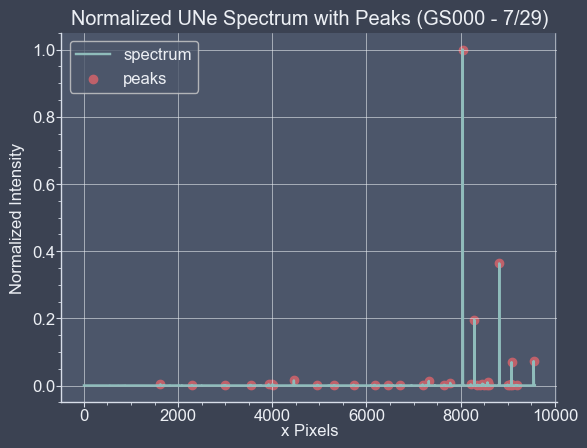

In [18]:
UNe_729_peak_locs, UNe_729_peak_vals, UNe_729_fw, UNe_729_fwhm = sf.find_peaks(UNe_spec_729, 0.001)
plt.plot(figsize = (12,4))
plt.title('Normalized UNe Spectrum with Peaks (GS000 - 7/29)')
plt.plot(UNe_spec_729, label = 'spectrum')
plt.scatter(UNe_729_peak_locs, UNe_729_peak_vals, color = '#bf616a', label = 'peaks')

plt.ylabel('Normalized Intensity')
plt.xlabel('x Pixels', va='center')
# plt.xlim(3500,4000)
# plt.ylim(0,5e-4)
plt.legend()
plt.show()

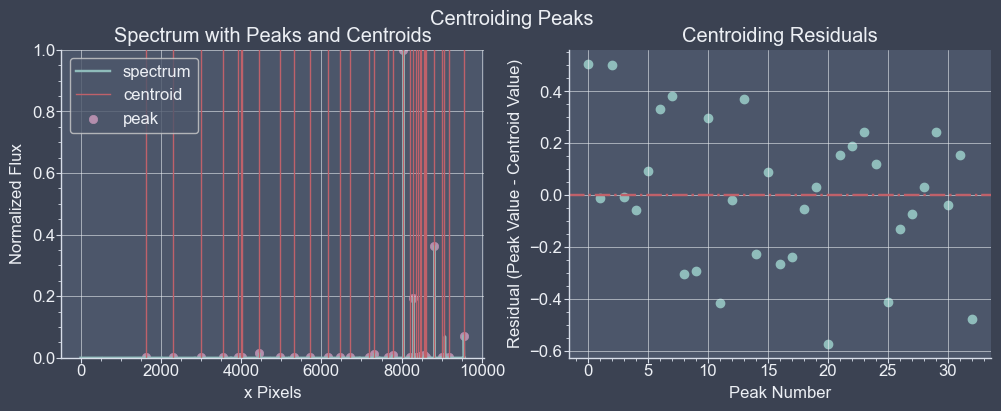

In [19]:
UNe_729_peak_props = np.array([UNe_729_peak_locs, UNe_729_peak_vals, UNe_729_fw, UNe_729_fwhm])
UNe_729_peak_locs_clean, UNe_729_peak_vals_clean, UNe_729_fw_clean, UNe_729_fwhm_clean = sf.clean_peaks(UNe_729_peak_props)
UNe_729_peak_props_clean = np.array([UNe_729_peak_locs_clean, UNe_729_peak_vals_clean, UNe_729_fw_clean, UNe_729_fwhm_clean])

UNe_pix_729 = np.linspace(0, UNe_spec_729.size - 1, UNe_spec_729.size)
UNe_centers_729, UNe_res_729 = sf.centroid(UNe_spec_729, UNe_pix_729, UNe_729_peak_props_clean)
plt.show()

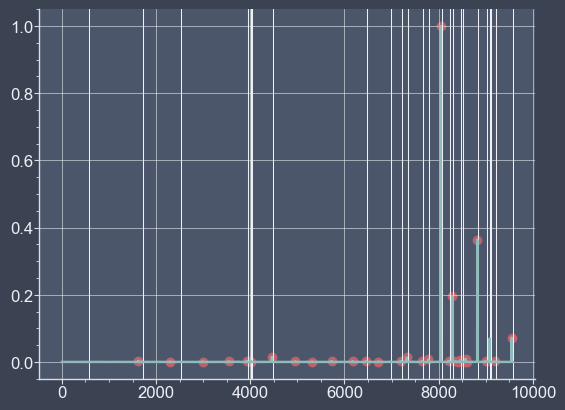

In [20]:
known_pix = np.flipud(UNe_peaks['Pixel'])
known_wav = np.flipud(UNe_peaks['Wavelength'])
known_peak = np.flipud(UNe_peaks['Intensity'] / 200)
for pix in range(known_pix.size):
    plt.axvline(known_pix[pix], color = '#eceff4', label = 'NIST Ne Peaks', lw = 0.75)
plt.plot(UNe_spec_729, label = 'Spectrum')
plt.scatter(UNe_centers_729, UNe_729_peak_vals_clean, label = 'Centroids', color = '#bf616a')
# plt.xlim(8950,10000)
plt.show()

In [21]:
remove_index_known = np.array([0, 20])
remove_index_id = np.array([2, 3, 8, 9, 10, 11, 21, 22, 25, 26, 27])
known_peak_clean = np.delete(known_peak, remove_index_known)
known_pix_clean = np.delete(known_pix, remove_index_known)
UNe_729_peak_vals_clean_2 = np.delete(UNe_729_peak_vals_clean, remove_index_id)
UNe_729_peak_locs_clean_2 = np.delete(UNe_729_peak_locs_clean, remove_index_id)
UNe_centers_729_clean = np.delete(UNe_centers_729, remove_index_id)
known_wav_clean = np.delete(known_wav, remove_index_known)

# UNe_xcorr = plt.xcorr(known_peak_clean, UNe_centers_729_clean, maxlags = 21)
# plt.show()

In [22]:
# for x in range(len(UNe_xcorr[1])):
#     if UNe_xcorr[1][x] == max(UNe_xcorr[1]):
#         max_index = x
        
# offset = UNe_xcorr[0][max_index]
# differences = np.abs(np.diff(UNe_centers_729_clean))
# avg_seperation = np.mean(differences)
# pixel_offset = offset*avg_seperation
# print(pixel_offset)

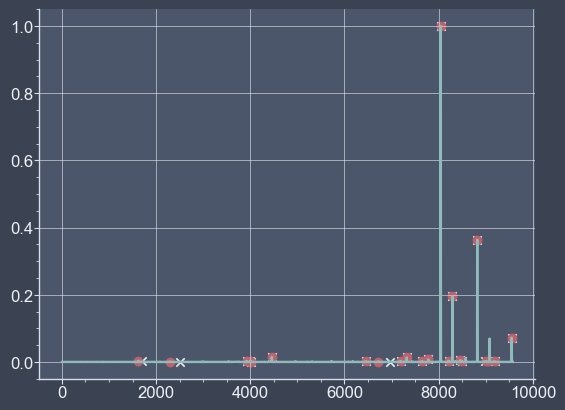

In [23]:
# print(known_pix_clean)
# print(UNe_centers_729_clean)

# offsets = np.array([])
# for x in range(len(known_pix_clean)):
#     offset = known_pix_clean[x] - UNe_centers_729_clean[x]
#     offsets = np.append(offsets, offset)

# print(np.mean(offsets))

known_pix_offset = known_pix_clean - 23

# print(known_pix_offset)
# for pix in range(known_pix_offset.size):
#     plt.axvline(known_pix_offset[pix], color = '#eceff4', label = 'NIST Ne Peaks', lw = 1.2)

plt.scatter(known_pix_offset, UNe_729_peak_vals_clean_2, label = 'NIST Ne Peaks', color = '#eceff4', marker = 'x', lw = 1.2)
plt.plot(UNe_spec_729, label = 'Spectrum')
plt.scatter(UNe_centers_729_clean, UNe_729_peak_vals_clean_2, label = 'Centroids', color = '#bf616a')
# plt.xlim(6000,7000)
# plt.ylim(0, 0.005)
plt.show()

In [24]:
UNe_GS001_wavesol = {'pixel': known_pix_offset, 'wavelength': known_wav_clean, 'intensity': UNe_729_peak_vals_clean_2}
UNe_GS001_df = pd.DataFrame(UNe_GS001_wavesol)
UNe_GS001_df.to_csv('UNe_729_wavesol.csv', index=False)

            3             2
-8.957e-11 x + 3.783e-07 x + 0.132 x + 4812


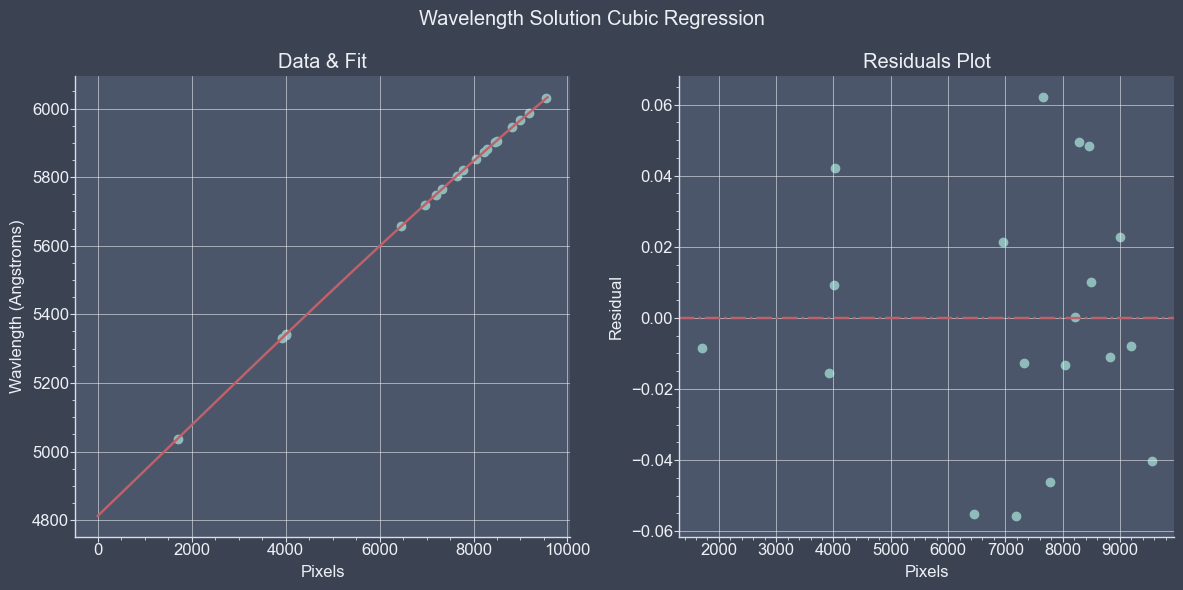

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Wavelength Solution Cubic Regression')

fit_pix = UNe_GS001_df.pixel
fit_wav = UNe_GS001_df.wavelength
remove_points = np.array([1, 5, 19])
fit_pix_clean = np.delete(fit_pix, remove_points)
fit_wav_clean = np.delete(fit_wav, remove_points)

ax[0].scatter(fit_pix_clean, fit_wav_clean)

coeff = np.polyfit(fit_pix_clean, fit_wav_clean, 3)
eq = np.poly1d(coeff)
print(eq)
wavesol_fit = eq(UNe_pix_729)

ax[0].plot(UNe_pix_729, wavesol_fit, '#bf616a')
ax[0].set_title('Data & Fit')
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Wavlength (Angstroms)')

residuals = np.array([])
for y in range(len(fit_pix_clean)):
    eval_index = fit_pix_clean[y]
    res = eq(eval_index) - fit_wav_clean[y]
    residuals = np.append(residuals, res)
    
ax[1].scatter(fit_pix_clean, residuals)
ax[1].axhline(0, ls = "-.", c = '#bf616a')
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Pixels')
ax[1].set_title('Residuals Plot')
fig.tight_layout()
plt.show()

In [ ]:
plt.plot(wavesol_fit, UNe_spec_729, label = 'Spectrum')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Intensity')
plt.title('UNe (7/29) Spectrum')
plt.show()

In [ ]:
#median of bias frames stack (8/5)
bias_path_85 = f'Lab_day_080525/Bias_85/2025-08-05_18_26_19Z/2025-08-05-1826_3-CapObj_'
bias_shape_85 = fits.open(f'Lab_day_080525/Bias_85/2025-08-05_18_26_19Z/2025-08-05-1826_3-CapObj_0026.FIT')[0].data.shape
bias_avg_85 = sf.median_img(10, bias_path_85, bias_shape_85[0], bias_shape_85[1])

plt.figure(figsize = (12,12))
plt.imshow(bias_avg_85)
plt.title('Bias Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

In [ ]:
#median of ThAr lights stack (8/5)
ThAr_lights_path_01_85 = f'Lab_day_080525/ThAr001_lights/2025-08-05_18_04_33Z/2025-08-05-1804_5-CapObj_'
ThAr_lights_shape_01_85 = fits.open(f'Lab_day_080525/ThAr001_lights/2025-08-05_18_04_33Z/2025-08-05-1804_5-CapObj_0016.FIT')[0].data.shape
ThAr_lights_avg_01_85 = sf.median_img(10, ThAr_lights_path_01_85, ThAr_lights_shape_01_85[0], ThAr_lights_shape_01_85[1])

ThAr_lights_avg_01_85 = ThAr_lights_avg_01_85 - bias_avg_85

plt.figure(figsize = (12,12))
plt.imshow(ThAr_lights_avg_01_85, norm = 'log')
plt.title('ThAr Lights Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

In [ ]:
#median of ThAr darks stack
ThAr_darks_path_01_85 = f'Lab_day_080525/ThAr001_darks/2025-08-05_18_12_49Z/2025-08-05-1812_8-CapObj_'
ThAr_darks_shape_01_85 = fits.open(f'Lab_day_080525/ThAr001_darks/2025-08-05_18_12_49Z/2025-08-05-1812_8-CapObj_0072.FIT')[0].data.shape
ThAr_darks_avg_01_85 = sf.median_img(10, ThAr_darks_path_01_85, ThAr_darks_shape_01_85[0], ThAr_darks_shape_01_85[1])

ThAr_darks_avg_01_85 = ThAr_darks_avg_01_85 - bias_avg_85

plt.figure(figsize = (12,12))
plt.imshow(ThAr_darks_avg_01_85)
plt.title('ThAr Darks Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

In [ ]:
ThAr_subtracted_01_85 = ThAr_lights_avg_01_85 - ThAr_darks_avg_01_85
ThAr_flipped_01_85 = np.fliplr(ThAr_subtracted_01_85)

plt.figure(figsize = (12,12))
plt.imshow(ThAr_flipped_01_85, norm = 'log', vmin = 1, vmax = 10**4.3)
plt.title('ThAr Stack Average (GS001)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.07, norm = 'log')

plt.show()

In [ ]:
ThAr_corrected_01_85 = sf.straight_spec(ThAr_flipped_01_85)

In [ ]:
ThAr_corrected_01_85 = sf.straight_spec(ThAr_corrected_01_85)

In [ ]:
ThAr_spec_01_85 = sf.make1D(ThAr_corrected_01_85, False)
plt.plot(wavesol_fit, ThAr_spec_01_85)
plt.title('GS001 Spectrum')
plt.ylabel('Normalized Intensity') #percentage of total intensity in each peak
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.xlim(4800,6050)
plt.ylim(0, 1.1)
plt.show()

In [ ]:
ThAr_peak_props_01_85 = sf.find_peaks(ThAr_spec_01_85, 0.2)
# ThAr_peak_props_clean_01_85 = sf.clean_peaks(ThAr_peak_props_01_85)
# ThAr_peak_locs_clean_01_85, ThAr_peak_vals_clean_01_85, ThAr_fw_clean_01_85, ThAr_fwhm_clean_01_85 = ThAr_peak_props_clean_01_85
ThAr_peak_locs_01_85, ThAr_peak_vals_01_85,ThAr_fw_01_85, ThAr_fwhm_01_85 = ThAr_peak_props_01_85 

plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS001 - 8/5)')
plt.plot(wavesol_fit, ThAr_spec_01_85, label = 'spectrum')
plt.scatter(eq(ThAr_peak_locs_01_85), ThAr_peak_vals_01_85, color = '#bf616a', label = 'peaks')

#finding triplet
for peak in range(len(ThAr_peak_locs_01_85)):
    if ThAr_peak_vals_01_85[peak] == 1:
        main_index = peak
        break
        
poi_loc_01_85 = np.array([ThAr_peak_locs_01_85[main_index - 1], ThAr_peak_locs_01_85[main_index], ThAr_peak_locs_01_85[main_index + 1]])        
poi_i_01_85 = np.array([ThAr_peak_vals_01_85[main_index - 1], ThAr_peak_vals_01_85[main_index], ThAr_peak_vals_01_85[main_index + 1]])
poi_fw_01_85 = np.array([ThAr_fw_01_85[main_index - 1], ThAr_fw_01_85[main_index], ThAr_fw_01_85[main_index + 1]])
poi_fwhm_01_85 = np.array([ThAr_fwhm_01_85[main_index - 1], ThAr_fwhm_01_85[main_index], ThAr_fwhm_01_85[main_index + 1]])

poi_props_01_85 = poi_loc_01_85, poi_i_01_85, poi_fw_01_85, poi_fwhm_01_85

plt.scatter(eq(poi_loc_01_85), poi_i_01_85, label = 'POI', color = '#eceff4', marker = '*', lw = 5)
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5700, 5820)
plt.show()

In [ ]:
ThAr_pix_01_85 = np.linspace(0, ThAr_spec_01_85.size - 1, ThAr_spec_01_85.size)
ThAr_centers_poi_01_85, ThAr_res_poi_01_85 = sf.centroid(ThAr_spec_01_85, ThAr_pix_01_85, poi_props_01_85)

plt.show()

In [ ]:
poi_known_wave = np.array([5720.18, 5760.55, 5804.14])
poi_known_i = np.array([0.585, 1, 0.34])

plt.plot(wavesol_fit, ThAr_spec_01_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(eq(ThAr_centers_poi_01_85),poi_i_01_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS001)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
print(np.diff(eq(ThAr_centers_poi)))
print(np.diff(poi_known_wave))

ThAr_centers_spread = np.zeros(1000)
ThAr_centers_spread = np.insert(ThAr_centers_spread, [0, 404, 404+436], poi_i)

poi_known_spread = np.zeros(1000)
poi_known_spread = np.insert(poi_known_spread, [0, 404, 404+436], poi_known_i)

ThAr_01_85_xcorr = plt.xcorr(poi_known_spread, ThAr_centers_spread, maxlags = 1)
plt.show()
print(ThAr_01_85_xcorr)

In [ ]:
offset_01_85 = eq(ThAr_centers_poi_01_85) - poi_known_wave
# avg_offset = np.full((1, wavesol_fit.size), np.mean(offset))
avg_offset_01_85 = np.mean(offset_01_85)
print(avg_offset_01_85)
wavesol_fit_offset_01_85 = wavesol_fit - avg_offset_01_85
ThAr_centers_poi_offset_01_85 = eq(ThAr_centers_poi_01_85) - avg_offset_01_85

plt.plot(wavesol_fit_offset_01_85, ThAr_spec_01_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(ThAr_centers_poi_offset_01_85, poi_i_01_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS001)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
ThAr_spec_norm_01_85 = sf.make1D(ThAr_corrected_01_85)
plt.plot(wavesol_fit_offset_01_85, ThAr_spec_norm_01_85, label = 'Spectrum', lw = 1.5)
plt.title('ThAr Spectrum (GS001)')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(4800, 6050)
plt.ylim(0, .016)
# plt.savefig('ThAr_GS001_sol.png')
plt.show()

wavesol_data_01_85 = {'pixel': ThAr_pix_01_85, 'intensity': ThAr_spec_norm_01_85, 'wavelength':wavesol_fit_offset_01_85}
wavesol_data_01_85_df = pd.DataFrame(wavesol_data_01_85)
wavesol_data_01_85_df.to_csv('GS001_wavesol_85.csv', index=False)

In [ ]:
#median of ThAr lights stack (8/5)
ThAr_lights_path_02_85 = f'Lab_day_080525/ThAr002_lights/2025-08-05_20_41_40Z/2025-08-05-2041_6-CapObj_'
ThAr_lights_shape_02_85 = fits.open(f'Lab_day_080525/ThAr002_lights/2025-08-05_20_41_40Z/2025-08-05-2041_6-CapObj_0043.FIT')[0].data.shape
ThAr_lights_avg_02_85 = sf.median_img(10, ThAr_lights_path_02_85, ThAr_lights_shape_02_85[0], ThAr_lights_shape_02_85[1])

ThAr_lights_avg_02_85 = ThAr_lights_avg_02_85 - bias_avg_85

plt.figure(figsize = (12,12))
plt.imshow(ThAr_lights_avg_02_85, norm = 'log')
plt.title('ThAr Lights Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

In [ ]:
ThAr_darks_path_02_85 = f'Lab_day_080525/ThAr002_darks/2025-08-05_20_46_38Z/2025-08-05-2046_6-CapObj_'
ThAr_darks_shape_02_85 = fits.open(f'Lab_day_080525/ThAr002_darks/2025-08-05_20_46_38Z/2025-08-05-2046_6-CapObj_0030.FIT')[0].data.shape
ThAr_darks_avg_02_85 = sf.median_img(10, ThAr_darks_path_02_85, ThAr_darks_shape_02_85[0], ThAr_darks_shape_02_85[1])

ThAr_darks_avg_02_85 = ThAr_darks_avg_02_85 - bias_avg_85

plt.figure(figsize = (12,12))
plt.imshow(ThAr_darks_avg_02_85)
plt.title('ThAr Darks Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

In [ ]:
ThAr_subtracted_02_85 = ThAr_lights_avg_02_85 - ThAr_darks_avg_02_85
ThAr_flipped_02_85 = np.fliplr(ThAr_subtracted_02_85)

plt.figure(figsize = (12,12))
plt.imshow(ThAr_flipped_02_85, norm = 'log', vmin = 1, vmax = 10**4.3)
plt.title('ThAr Stack Average (GS002)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.07, norm = 'log')

plt.show()

In [ ]:
ThAr_corrected_02_85 = sf.straight_spec(ThAr_flipped_02_85)

In [ ]:
plt.figure(figsize = (3,3))
plt.imshow(ThAr_corrected_02_85, norm = 'log', vmin = 10**-2, vmax = 10**4.3)
plt.title('ThAr Spectra (GS002)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.xlim(5000, 5500)
plt.ylim(350, 600)
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.2)
plt.savefig('GS002_img_zoom')
plt.show()

In [ ]:
ThAr_spec_02_85 = sf.make1D(ThAr_corrected_02_85, False)
plt.plot(wavesol_fit, ThAr_spec_02_85)
plt.title('GS002 Spectrum')
plt.ylabel('Normalized Intensity') #percentage of total intensity in each peak
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.xlim(4800,6050)
plt.ylim(0, 1.1)
plt.show()

In [ ]:
ThAr_peak_props_02_85 = sf.find_peaks(ThAr_spec_02_85, 0.2)
# ThAr_peak_props_clean_01_85 = sf.clean_peaks(ThAr_peak_props_01_85)
# ThAr_peak_locs_clean_01_85, ThAr_peak_vals_clean_01_85, ThAr_fw_clean_01_85, ThAr_fwhm_clean_01_85 = ThAr_peak_props_clean_01_85
ThAr_peak_locs_02_85, ThAr_peak_vals_02_85,ThAr_fw_02_85, ThAr_fwhm_02_85 = ThAr_peak_props_02_85 

plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS0012- 8/5)')
plt.plot(wavesol_fit, ThAr_spec_02_85, label = 'spectrum')
plt.scatter(eq(ThAr_peak_locs_02_85), ThAr_peak_vals_02_85, color = '#bf616a', label = 'peaks')

#finding triplet
# for peak in range(len(ThAr_peak_locs_02_85)):
#     if ThAr_peak_vals_02_85[peak] == 1:
#         main_index = peak
#         break
        
poi_loc_02_85 = np.array([ThAr_peak_locs_02_85[12], ThAr_peak_locs_02_85[13], ThAr_peak_locs_02_85[11]])        
poi_i_02_85 = np.array([ThAr_peak_vals_02_85[12], ThAr_peak_vals_02_85[13], ThAr_peak_vals_02_85[11]])
poi_fw_02_85 = np.array([ThAr_fw_02_85[12], ThAr_fw_02_85[13], ThAr_fw_02_85[11]])
poi_fwhm_02_85 = np.array([ThAr_fwhm_02_85[12], ThAr_fwhm_02_85[13], ThAr_fwhm_02_85[11]])

poi_props_02_85 = poi_loc_02_85, poi_i_02_85, poi_fw_02_85, poi_fwhm_02_85

plt.scatter(eq(poi_loc_02_85), poi_i_02_85, label = 'POI', color = '#eceff4', marker = '*', lw = 5)
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.show()

In [ ]:
ThAr_pix_02_85 = np.linspace(0, ThAr_spec_02_85.size - 1, ThAr_spec_02_85.size)
ThAr_centers_poi_02_85, ThAr_res_poi_02_85 = sf.centroid(ThAr_spec_02_85, ThAr_pix_02_85, poi_props_02_85)

plt.show()

In [ ]:
plt.plot(wavesol_fit, ThAr_spec_02_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(eq(ThAr_centers_poi_02_85),poi_i_02_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
print(eq(ThAr_centers_poi_02_85))
plt.legend()
plt.title('Centroided ThAr Spectrum (GS002)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
offset_02_85 = eq(ThAr_centers_poi_02_85) - poi_known_wave
avg_offset_02_85 = np.mean(offset_02_85)

wavesol_fit_offset_02_85 = wavesol_fit - avg_offset_02_85
ThAr_centers_poi_offset_02_85 = eq(ThAr_centers_poi_02_85) - avg_offset_02_85
ThAr_spec_norm_02_85 = sf.make1D(ThAr_corrected_02_85)

plt.plot(wavesol_fit_offset_02_85, ThAr_spec_02_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(ThAr_centers_poi_offset_02_85, poi_i_02_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS002)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
# plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

wavesol_data_02_85 = {'pixel': ThAr_pix_02_85, 'intensity': ThAr_spec_norm_02_85, 'wavelength':wavesol_fit_offset_02_85}
wavesol_data_02_85_df = pd.DataFrame(wavesol_data_02_85)
wavesol_data_02_85_df.to_csv('GS002_wavesol_85.csv', index=False)

In [ ]:
#median of ThAr lights stack (8/5)
ThAr_lights_path_03_85 = f'Lab_day_080525/ThAr003_lights/2025-08-05_20_25_06Z/2025-08-05-2025_1-CapObj_'
ThAr_lights_shape_03_85 = fits.open(f'Lab_day_080525/ThAr003_lights/2025-08-05_20_25_06Z/2025-08-05-2025_1-CapObj_0058.FIT')[0].data.shape
ThAr_lights_avg_03_85 = sf.median_img(10, ThAr_lights_path_03_85, ThAr_lights_shape_03_85[0], ThAr_lights_shape_03_85[1])

ThAr_lights_avg_03_85 = ThAr_lights_avg_03_85 - bias_avg_85

In [ ]:
ThAr_darks_path_03_85 = f'Lab_day_080525/ThAr003_darks/2025-08-05_20_30_09Z/2025-08-05-2030_1-CapObj_'
ThAr_darks_shape_03_85 = fits.open(f'Lab_day_080525/ThAr003_darks/2025-08-05_20_30_09Z/2025-08-05-2030_1-CapObj_0011.FIT')[0].data.shape
ThAr_darks_avg_03_85 = sf.median_img(10, ThAr_darks_path_03_85, ThAr_darks_shape_03_85[0], ThAr_darks_shape_03_85[1])

ThAr_darks_avg_03_85 = ThAr_darks_avg_03_85 - bias_avg_85

In [ ]:
ThAr_subtracted_03_85 = ThAr_lights_avg_03_85 - ThAr_darks_avg_03_85
ThAr_flipped_03_85 = np.fliplr(ThAr_subtracted_03_85)

In [ ]:
ThAr_corrected_03_85 = sf.straight_spec(ThAr_flipped_03_85)

In [ ]:
ThAr_corrected_03_85 = sf.straight_spec(ThAr_corrected_03_85)

In [ ]:
ThAr_spec_03_85 = sf.make1D(ThAr_corrected_03_85, False)

ThAr_peak_props_03_85 = sf.find_peaks(ThAr_spec_03_85, 0.2)
ThAr_peak_locs_03_85, ThAr_peak_vals_03_85,ThAr_fw_03_85, ThAr_fwhm_03_85 = ThAr_peak_props_03_85 

plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS003- 8/5)')
plt.plot(wavesol_fit, ThAr_spec_03_85, label = 'spectrum')
plt.scatter(eq(ThAr_peak_locs_03_85), ThAr_peak_vals_03_85, color = '#bf616a', label = 'peaks')

# finding triplet
main_index = 13
poi_loc_03_85 = np.array([ThAr_peak_locs_03_85[main_index - 1], ThAr_peak_locs_03_85[main_index], ThAr_peak_locs_03_85[main_index + 1]])        
poi_i_03_85 = np.array([ThAr_peak_vals_03_85[main_index - 1], ThAr_peak_vals_03_85[main_index], ThAr_peak_vals_03_85[main_index + 1]])
poi_fw_03_85 = np.array([ThAr_fw_03_85[main_index - 1], ThAr_fw_03_85[main_index], ThAr_fw_03_85[main_index + 1]])
poi_fwhm_03_85 = np.array([ThAr_fwhm_03_85[main_index - 1], ThAr_fwhm_03_85[main_index], ThAr_fwhm_03_85[main_index + 1]])
poi_props_03_85 = poi_loc_03_85, poi_i_03_85, poi_fw_03_85, poi_fwhm_03_85

plt.scatter(eq(poi_loc_03_85), poi_i_03_85, label = 'POI', color = '#eceff4', marker = '*', lw = 5)
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.show()

In [ ]:
ThAr_pix_03_85 = np.linspace(0, ThAr_spec_03_85.size - 1, ThAr_spec_03_85.size)
ThAr_centers_poi_03_85, ThAr_res_poi_03_85 = sf.centroid(ThAr_spec_03_85, ThAr_pix_03_85, poi_props_03_85)

plt.show()

In [ ]:
plt.plot(wavesol_fit, ThAr_spec_02_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(eq(ThAr_centers_poi_02_85),poi_i_02_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
print(eq(ThAr_centers_poi_02_85))
plt.legend()
plt.title('Centroided ThAr Spectrum (GS002)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
offset_03_85 = eq(ThAr_centers_poi_03_85) - poi_known_wave
avg_offset_03_85 = np.mean(offset_03_85)

wavesol_fit_offset_03_85 = wavesol_fit - avg_offset_03_85
ThAr_centers_poi_offset_03_85 = eq(ThAr_centers_poi_03_85) - avg_offset_03_85
ThAr_spec_norm_03_85 = sf.make1D(ThAr_corrected_03_85)

plt.plot(wavesol_fit_offset_03_85, ThAr_spec_03_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(ThAr_centers_poi_offset_03_85, poi_i_03_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS003)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

wavesol_data_03_85 = {'pixel': ThAr_pix_03_85, 'intensity': ThAr_spec_norm_03_85, 'wavelength':wavesol_fit_offset_03_85}
wavesol_data_03_85_df = pd.DataFrame(wavesol_data_03_85)
wavesol_data_03_85_df.to_csv('GS003_wavesol_85.csv', index=False)

In [ ]:
#median of ThAr lights stack
ThAr_lights_path_04_85 = f'Lab_day_080525/ThAr004_lights/2025-08-05_20_58_52Z/2025-08-05-2058_8-CapObj_'
ThAr_lights_shape_04_85 = fits.open(f'Lab_day_080525/ThAr004_lights/2025-08-05_20_58_52Z/2025-08-05-2058_8-CapObj_0045.FIT')[0].data.shape
ThAr_lights_avg_04_85 = sf.median_img(10, ThAr_lights_path_04_85, ThAr_lights_shape_04_85[0], ThAr_lights_shape_04_85[1])

ThAr_lights_avg_04_85 = ThAr_lights_avg_04_85 - bias_avg_85

In [ ]:
#median of ThAr darks stack
ThAr_darks_path_04_85 = f'Lab_day_080525/ThAr004_darks/2025-08-05_21_03_49Z/2025-08-05-2103_8-CapObj_'
ThAr_darks_shape_04_85 = fits.open(f'Lab_day_080525/ThAr004_darks/2025-08-05_21_03_49Z/2025-08-05-2103_8-CapObj_0058.FIT')[0].data.shape
ThAr_darks_avg_04_85 = sf.median_img(10, ThAr_darks_path_04_85, ThAr_darks_shape_04_85[0], ThAr_darks_shape_04_85[1])

ThAr_darks_avg_04_85 = ThAr_darks_avg_04_85 - bias_avg_85

In [ ]:
ThAr_subtracted_04_85 = ThAr_lights_avg_04_85 - ThAr_darks_avg_04_85
ThAr_flipped_04_85 = np.fliplr(ThAr_subtracted_04_85)

In [ ]:
ThAr_corrected_04_85 = sf.straight_spec(ThAr_flipped_04_85)

In [ ]:
ThAr_corrected_04_85 = np.abs(ThAr_corrected_04_85)
ThAr_spec_04_85 = sf.make1D(ThAr_corrected_04_85, False)

ThAr_peak_props_04_85 = sf.find_peaks(ThAr_spec_04_85, 0.05)
ThAr_peak_locs_04_85, ThAr_peak_vals_04_85,ThAr_fw_04_85, ThAr_fwhm_04_85 = ThAr_peak_props_04_85 

plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS004- 8/5)')
plt.plot(wavesol_fit, ThAr_spec_04_85, label = 'spectrum')
plt.scatter(eq(ThAr_peak_locs_04_85), ThAr_peak_vals_04_85, color = '#bf616a', label = 'peaks')

# finding triplet
main_index = 33
poi_loc_04_85 = np.array([ThAr_peak_locs_04_85[main_index - 2], ThAr_peak_locs_04_85[main_index], ThAr_peak_locs_04_85[main_index + 3]])        
poi_i_04_85 = np.array([ThAr_peak_vals_04_85[main_index - 2], ThAr_peak_vals_04_85[main_index], ThAr_peak_vals_04_85[main_index + 3]])
poi_fw_04_85 = np.array([ThAr_fw_04_85[main_index - 2], ThAr_fw_04_85[main_index], ThAr_fw_04_85[main_index + 3]])
poi_fwhm_04_85 = np.array([ThAr_fwhm_04_85[main_index - 2], ThAr_fwhm_04_85[main_index], ThAr_fwhm_04_85[main_index + 3]])
poi_props_04_85 = poi_loc_04_85, poi_i_04_85, poi_fw_04_85, poi_fwhm_04_85

plt.scatter(eq(poi_loc_04_85), poi_i_04_85, label = 'POI', color = '#eceff4', marker = '*', lw = 5)
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5850)
# plt.ylim(-0.0002,0.0002)
# plt.xlim(5800, 5850)
plt.show()

In [ ]:
ThAr_pix_04_85 = np.linspace(0, ThAr_spec_04_85.size - 1, ThAr_spec_04_85.size)
ThAr_centers_poi_04_85, ThAr_res_poi_04_85 = sf.centroid(ThAr_spec_04_85, ThAr_pix_04_85, poi_props_04_85)

plt.show()

In [ ]:
plt.plot(wavesol_fit, ThAr_spec_04_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(eq(ThAr_centers_poi_04_85),poi_i_04_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
print(eq(ThAr_centers_poi_04_85))
plt.legend()
plt.title('Centroided ThAr Spectrum (GS004)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
# plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
offset_04_85 = eq(ThAr_centers_poi_04_85) - poi_known_wave
avg_offset_04_85 = np.mean(offset_04_85)
print(avg_offset_04_85)

wavesol_fit_offset_04_85 = wavesol_fit - avg_offset_04_85
ThAr_centers_poi_offset_04_85 = eq(ThAr_centers_poi_04_85) - avg_offset_04_85
ThAr_spec_norm_04_85 = sf.make1D(ThAr_corrected_04_85)

plt.plot(wavesol_fit_offset_04_85, ThAr_spec_04_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(ThAr_centers_poi_offset_04_85, poi_i_04_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS003)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
# plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

wavesol_data_04_85 = {'pixel': ThAr_pix_04_85, 'intensity': ThAr_spec_norm_04_85, 'wavelength':wavesol_fit_offset_04_85}
wavesol_data_04_85_df = pd.DataFrame(wavesol_data_04_85)
wavesol_data_04_85_df.to_csv('GS004_wavesol_85.csv', index=False)

In [ ]:
#median of ThAr lights stack
ThAr_lights_path_05_85 = f'Lab_day_080525/ThAr005_lights/2025-08-05_21_18_10Z/2025-08-05-2118_1-CapObj_'
ThAr_lights_shape_05_85 = fits.open(f'Lab_day_080525/ThAr005_lights/2025-08-05_21_18_10Z/2025-08-05-2118_1-CapObj_0052.FIT')[0].data.shape
ThAr_lights_avg_05_85 = sf.median_img(10, ThAr_lights_path_05_85, ThAr_lights_shape_05_85[0], ThAr_lights_shape_05_85[1])

ThAr_lights_avg_05_85 = ThAr_lights_avg_05_85 - bias_avg_85

In [ ]:
#median of ThAr darks stack
ThAr_darks_path_05_85 = f'Lab_day_080525/ThAr005_darks/2025-08-05_21_23_18Z/2025-08-05-2123_3-CapObj_'
ThAr_darks_shape_05_85 = fits.open(f'Lab_day_080525/ThAr005_darks/2025-08-05_21_23_18Z/2025-08-05-2123_3-CapObj_0047.FIT')[0].data.shape
ThAr_darks_avg_05_85 = sf.median_img(10, ThAr_darks_path_05_85, ThAr_darks_shape_05_85[0], ThAr_darks_shape_05_85[1])

ThAr_darks_avg_05_85 = ThAr_darks_avg_05_85 - bias_avg_85

In [ ]:
ThAr_subtracted_05_85 = ThAr_lights_avg_05_85 - ThAr_darks_avg_05_85
ThAr_flipped_05_85 = np.fliplr(ThAr_subtracted_05_85)

In [ ]:
ThAr_corrected_05_85 = sf.straight_spec(ThAr_flipped_05_85)

In [ ]:
ThAr_spec_05_85 = sf.make1D(ThAr_corrected_05_85, False)

ThAr_peak_props_05_85 = sf.find_peaks(ThAr_spec_05_85, 0.2)
ThAr_peak_locs_05_85, ThAr_peak_vals_05_85,ThAr_fw_05_85, ThAr_fwhm_05_85 = ThAr_peak_props_05_85 

plt.plot(figsize = (12,4))
plt.title('Normalized Spectrum with Peaks (GS005- 8/5)')
plt.plot(wavesol_fit, ThAr_spec_05_85, label = 'spectrum')
plt.scatter(eq(ThAr_peak_locs_05_85), ThAr_peak_vals_05_85, color = '#bf616a', label = 'peaks')

# finding triplet
for peak in range(len(ThAr_peak_locs_05_85)):
    if ThAr_peak_vals_05_85[peak] == 1:
        main_index = peak
        break
poi_loc_05_85 = np.array([ThAr_peak_locs_05_85[main_index - 1], ThAr_peak_locs_05_85[main_index], ThAr_peak_locs_05_85[main_index + 1]])        
poi_i_05_85 = np.array([ThAr_peak_vals_05_85[main_index - 1], ThAr_peak_vals_05_85[main_index], ThAr_peak_vals_05_85[main_index + 1]])
poi_fw_05_85 = np.array([ThAr_fw_05_85[main_index - 1], ThAr_fw_05_85[main_index], ThAr_fw_05_85[main_index + 1]])
poi_fwhm_05_85 = np.array([ThAr_fwhm_05_85[main_index - 1], ThAr_fwhm_05_85[main_index], ThAr_fwhm_05_85[main_index + 1]])
poi_props_05_85 = poi_loc_05_85, poi_i_05_85, poi_fw_05_85, poi_fwhm_05_85

plt.scatter(eq(poi_loc_05_85), poi_i_05_85, label = 'POI', color = '#eceff4', marker = '*', lw = 5)
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.show()

In [ ]:
ThAr_pix_05_85 = np.linspace(0, ThAr_spec_05_85.size - 1, ThAr_spec_05_85.size)
ThAr_centers_poi_05_85, ThAr_res_poi_05_85 = sf.centroid(ThAr_spec_05_85, ThAr_pix_05_85, poi_props_05_85)

plt.show()

In [ ]:
plt.plot(wavesol_fit, ThAr_spec_05_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(eq(ThAr_centers_poi_05_85),poi_i_05_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
print(eq(ThAr_centers_poi_05_85))
plt.legend()
plt.title('Centroided ThAr Spectrum (GS005)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

In [ ]:
offset_05_85 = eq(ThAr_centers_poi_05_85) - poi_known_wave
avg_offset_05_85 = np.mean(offset_05_85)

wavesol_fit_offset_05_85 = wavesol_fit - avg_offset_05_85
ThAr_centers_poi_offset_05_85 = eq(ThAr_centers_poi_05_85) - avg_offset_05_85
ThAr_spec_norm_05_85 = sf.make1D(ThAr_corrected_05_85)

plt.plot(wavesol_fit_offset_05_85, ThAr_spec_05_85, label = 'Spectrum', lw = 1.5)
plt.scatter(poi_known_wave, poi_known_i, c = '#b48ead', label = 'Known Peaks', lw = 2)
plt.scatter(ThAr_centers_poi_offset_05_85, poi_i_05_85, marker = 'x', color = '#bf616a', lw = 2, label = 'Centroid') #centroid
plt.legend()
plt.title('Centroided ThAr Spectrum (GS003)')
plt.xlabel('Wavelength Approximation (Angstroms)')
plt.ylabel('Normalized Flux')
plt.xlim(5710, 5810)
# plt.ylim(0, 0.2)
plt.show()

wavesol_data_05_85 = {'pixel': ThAr_pix_05_85, 'intensity': ThAr_spec_norm_05_85, 'wavelength':wavesol_fit_offset_05_85}
wavesol_data_05_85_df = pd.DataFrame(wavesol_data_05_85)
wavesol_data_05_85_df.to_csv('GS005_wavesol_85.csv', index=False)

In [ ]:
fig, ax  = plt.subplots(3,1, figsize = (12, 9))
ax[0].imshow(ThAr_corrected_01_85, norm = 'log', vmin = 1, vmax = 10**4.3)
ax[0].set_title('GS001')
ax[1].imshow(ThAr_corrected_02_85, norm = 'log', vmin = 1, vmax = 10**4.3)
ax[1].set_title('GS002')
ax[1].set_ylabel('Pixels')
im3 = ax[2].imshow(ThAr_corrected_03_85, norm = 'log', vmin = 1, vmax = 10**4.3)
ax[2].set_title('GS003')
ax[2].set_xlabel('Pixels')
# plt.xlabel('Pixels')
# plt.ylabel('Pixels')
fig.colorbar(im3, ax = ax[2], shrink = 0.4, location = 'bottom', norm = 'log')

fig.tight_layout()
plt.savefig('contamination_img.png')
# fig.colorbar(im3, ax = ax[2], shrink = 0.4, location = 'bottom', pad = 0.5, norm = 'log')
plt.show()